 1. # google cloud provided  bert fine turne https://cloud.google.com/tpu/docs/tutorials/bert?authuser=1
 2.# https://github.com/google-research/bert/issues/934
 3. # parser: https://www.tensorflow.org/tutorials/load_data/tfrecord?authuser=1


# COLAB PRO: For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.


Steps to perform BERT Fine-tuning on Google Colab
1.	Infra setup (Change Runtime to TPU)
2.	Clone bert github repo
BERT has released BERT-Base and BERT-Large models, that have uncased and 
BERT-Large-Uncased Model  download using:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip
# Unzip the pretrained model
!unzip uncased_L-24_H-1024_A-16.zip
4.	Download the BIOASK Dataset
5.	Set up your TPU environment
6.	Create an output directory( Google cloud and storage)
7.	Move Pretrained Model to GCS Bucket
8.	Training



In [ ]:
######################### debugging ###########################
#url = "https://www.ncbi.nlm.nih.gov/pubmed/28034892"
# soup.find_all('tag_name', class_="class_name")
from bs4 import BeautifulSoup
import requests
# url="https://www.ncbi.nlm.nih.gov/pubmed/28034892"
# r = requests.get(url) #download the page  and access content of the page using the content property(page.content):
# now have downloaded an HTML document.We can use the BeautifulSoup library to parse this document, and extract the text from and prettyfy() to clean the data
try:
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html.parser')
  # soup.title.get_text()
  abstract = soup.find_all(class_="review-container")
  print(abstract)
  print("###########################  link ##########################")
  print(abstract[0].find_all('a', class_ = "title"))
  print("####################### comment ##########################")
  print(abstract[0].find_all('div', class_="text show-more__control"))
  print('*********** rating  ************')
  print(abstract[1].find_next('span', class_="rating-other-user-rating").find_all('span'))#ext('div',{'id':'id_value'}).findAll('a') 
  # abstract_plus_title = abstract.get_text()
  # abstract_text = abstract_plus_title
  # print(abstract_text)
except IndexError:
  abstract_text = "missing abstract"

[<div class="review-container">
<div class="lister-item-content">
<a class="title" href="/review/rw3038370/"> The Pinnacle Of Flawless Films!
</a> <div class="display-name-date">
<span class="display-name-link"><a href="/user/ur24740649/">CalRhys</a></span><span class="review-date">20 June 2014</span>
</div>
<span class="spoiler-warning">Warning: Spoilers</span>
<div class="ipl-expander ">
<div class="ipl-expander__container">
<div class="expander-icon-wrapper spoiler-warning__control">
<svg class="ipl-expander__icon expander-icon " height="8" viewbox="0 0 12 8" width="12" xmlns="http://www.w3.org/2000/svg">
<path d="M10.197 0L6 4.304 1.803 0 0 1.85 6 8l6-6.15" fill="#2572B3" fill-rule="evenodd"></path>
</svg>
</div>
</div>
</div>
<div class="content">
<div class="text show-more__control">'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my a

In [ ]:
father.findNext('div',{'class':'class_value'}).findNext('div',{'id':'id_value'}).findAll('a') 
#Above code can imitate the following xpath:

div[class=class_value]/div[id=id_value]

SyntaxError: ignored

In [ ]:
 url = ' https://www.imdb.com/title/tt0068646/reviews?ref_=tt_ov_rt'
 abstract_readerwebScraping(url)
#  div class="review-container"

NameError: ignored

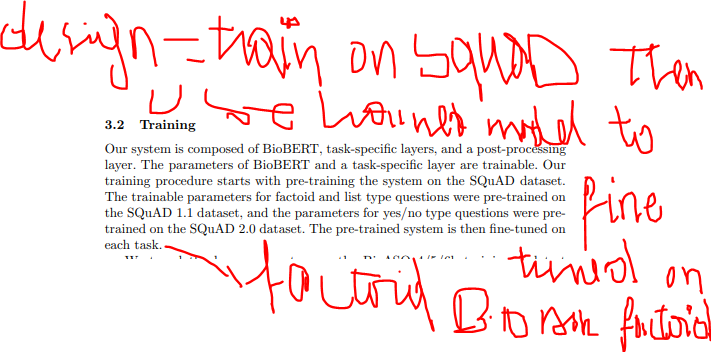

# **Set up TPU and  environment**
*   Verify that you are connected to a TPU device
*   You will get know your TPU Address that is used at time of fine-tuning
*   Perform Google Authentication to access your bucket
*   Upload your credentials to TPU to access your GCS bucket

In [ ]:
!pip install tensorflow-gpu==1.15.0 ### downgrade tensorflow version to make compatible to the run_squad

In [ ]:
import tensorflow
print(tensorflow.__version__)

In [ ]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
# TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# print('TPU address is => ', TPU_ADDRESS)


In [ ]:
# Measure test execution time
!pip install ipython-autotime
%load_ext autotime

## Setting up colab with  Google cloud

In [ ]:
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is => ', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

In [ ]:
# ### CONNECT TO GOOGLE DRIVE
# from google.colab import drive
# drive.mount('/content/drive')


# ***Data preprocessing***
*   load bioask data
*   do some high level EDA
*   prase the data to match with SQUAD V.20 fortmat
*   Save the date parse Bioask_squad json file into the Google bukcet

###  BIOSASK DATA FORMAT

In [ ]:
### "questions": [
      {
         "body": "Is Hirschsprung disease a mendelian or a multifactorial disorder?", 
         "documents": [
            "http://www.ncbi.nlm.nih.gov/pubmed/15858239", 
            "http://www.ncbi.nlm.nih.gov/pubmed/20598273", 
            "http://www.ncbi.nlm.nih.gov/pubmed/6650562", 
            "http://www.ncbi.nlm.nih.gov/pubmed/12239580", 
            "http://www.ncbi.nlm.nih.gov/pubmed/21995290", 
            "http://www.ncbi.nlm.nih.gov/pubmed/23001136", 
            "http://www.ncbi.nlm.nih.gov/pubmed/15617541", 
            "http://www.ncbi.nlm.nih.gov/pubmed/8896569", 
            "http://www.ncbi.nlm.nih.gov/pubmed/15829955"
         ], 
         "ideal_answer": [
            "Coding sequence mutations in RET, GDNF, EDNRB, EDN3, and SOX10 are involved in the development of Hirschsprung disease. The majority of these genes was shown to be related to Mendelian syndromic forms of Hirschsprung's disease, whereas the non-Mendelian inheritance of sporadic non-syndromic Hirschsprung disease proved to be complex; involvement of multiple loci was demonstrated in a multiplicative model."
         ], 
         "concepts": [
            "http://www.disease-ontology.org/api/metadata/DOID:10487", 
            "http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&exact=Find+Exact+Term&term=D006627", 
            "http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&exact=Find+Exact+Term&term=D020412", 
            "http://www.disease-ontology.org/api/metadata/DOID:11372"
         ], 
         "type": "summary", 
         "id": "55031181e9bde69634000014", 
         "snippets": [
            {
               "offsetInBeginSection": 131, 
               "offsetInEndSection": 358, 
               "text": "Hirschsprung disease (HSCR) is a multifactorial, non-mendelian disorder in which rare high-penetrance coding sequence mutations in the receptor tyrosine kinase RET contribute to risk in combination with mutations at other genes", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15829955", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 554, 
               "offsetInEndSection": 992, 
               "text": "In this study, we review the identification of genes and loci involved in the non-syndromic common form and syndromic Mendelian forms of Hirschsprung's disease. The majority of the identified genes are related to Mendelian syndromic forms of Hirschsprung's disease. The non-Mendelian inheritance of sporadic non-syndromic Hirschsprung's disease proved to be complex; involvement of multiple loci was demonstrated in a multiplicative model", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15617541", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 397, 
               "offsetInEndSection": 939, 
               "text": "Coding sequence mutations in e.g. RET, GDNF, EDNRB, EDN3, and SOX10 lead to long-segment (L-HSCR) as well as syndromic HSCR but fail to explain the transmission of the much more common short-segment form (S-HSCR). Furthermore, mutations in the RET gene are responsible for approximately half of the familial and some sporadic cases, strongly suggesting, on the one hand, the importance of non-coding variations and, on the other hand, that additional genes involved in the development of the enteric nervous system still await their discovery", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/12239580", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 941, 
               "offsetInEndSection": 1279, 
               "text": "For almost all of the identified HSCR genes incomplete penetrance of the HSCR phenotype has been reported, probably due to modifier loci. Therefore, HSCR has become a model for a complex oligo-/polygenic disorder in which the relationship between different genes creating a non-mendelian inheritance pattern still remains to be elucidated", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/12239580", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 129, 
               "offsetInEndSection": 358, 
               "text": " Hirschsprung disease (HSCR) is a multifactorial, non-mendelian disorder in which rare high-penetrance coding sequence mutations in the receptor tyrosine kinase RET contribute to risk in combination with mutations at other genes.", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15829955", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 851, 
               "offsetInEndSection": 1007, 
               "text": " The inheritance of Hirschsprung disease is generally consistent with sex-modified multifactorial inheritance with a lower threshold of expression in males.", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/6650562", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 131, 
               "offsetInEndSection": 359, 
               "text": "Hirschsprung disease (HSCR) is a multifactorial, non-mendelian disorder in which rare high-penetrance coding sequence mutations in the receptor tyrosine kinase RET contribute to risk in combination with mutations at other genes.", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15829955", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 0, 
               "offsetInEndSection": 131, 
               "text": "Differential contributions of rare and common, coding and noncoding Ret mutations to multifactorial Hirschsprung disease liability.", 
               "beginSection": "title", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/20598273", 
               "endSection": "title"
            }, 
            {
               "offsetInBeginSection": 0, 
               "offsetInEndSection": 210, 
               "text": "BACKGROUND: RET is the major gene associated to Hirschsprung disease (HSCR) with differential contributions of its rare and common, coding and noncoding mutations to the multifactorial nature of this pathology.", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/21995290", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 151, 
               "offsetInEndSection": 376, 
               "text": "In the etiology of Hirschsprung disease various genes play a role; these are: RET, EDNRB, GDNF, EDN3 and SOX10, NTN3, ECE1, Mutations in these genes may result in dominant, recessive or multifactorial patterns of inheritance.", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15858239", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 0, 
               "offsetInEndSection": 83, 
               "text": "Chromosomal and related Mendelian syndromes associated with Hirschsprung's disease.", 
               "beginSection": "title", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/23001136", 
               "endSection": "title"
            }, 
            {
               "offsetInBeginSection": 715, 
               "offsetInEndSection": 818, 
               "text": "The majority of the identified genes are related to Mendelian syndromic forms of Hirschsprung's disease", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15617541", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 151, 
               "offsetInEndSection": 375, 
               "text": "In the etiology of Hirschsprung disease various genes play a role; these are: RET, EDNRB, GDNF, EDN3 and SOX10, NTN3, ECE1, Mutations in these genes may result in dominant, recessive or multifactorial patterns of inheritance", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15858239", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 417, 
               "offsetInEndSection": 615, 
               "text": "On the basis of a skewed sex-ratio (M/F = 4/1) and a risk to relatives much higher than the incidence in the general population, HSCR has long been regarded as a sex-modified multifactorial disorder", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/8896569", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 858, 
               "offsetInEndSection": 1012, 
               "text": "The inheritance of Hirschsprung disease is generally consistent with sex-modified multifactorial inheritance with a lower threshold of expression in males", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/6650562", 
               "endSection": "abstract"
            }, 
            {
               "offsetInBeginSection": 820, 
               "offsetInEndSection": 992, 
               "text": "The non-Mendelian inheritance of sporadic non-syndromic Hirschsprung's disease proved to be complex; involvement of multiple loci was demonstrated in a multiplicative model", 
               "beginSection": "abstract", 
               "document": "http://www.ncbi.nlm.nih.gov/pubmed/15617541", 
               "endSection": "abstract"
            }
         ]
      }, 

In [ ]:
#upload the data to Colab environment need to run only once
from google.colab import files
uploaded = files.upload()

In [ ]:
#read uploade json file
import json
with open("trainining7b.json", "r") as reader:
  input_data = json.load(reader)

#### BIOSASK DATA EXPLORATION

In [ ]:
#read json contain
input_data = input_data['questions']

In [ ]:
print(input_data['questions'])

In [ ]:
dataframe = pd.DataFrame.from_dict(input_data)
dataframe.head(10)

In [ ]:
dataframe.rename(columns={"body": "question"}, inplace= True)

In [ ]:
dataframe.head(5)

In [ ]:
#aggregation of quetsion per type, ideal_answer and per exact answer then plot the graph also 
#plot histogram question per document count
plt.title('distribution of test across type of question')
p = sns.countplot(data=dataframe, x = 'type')
p.set_xticklabels(p.get_xticklabels(), rotation = 40, ha = "right")

In [ ]:
type_count = dataframe["type"].value_counts()
## convert value_count table to a dataframe
df_type_count = type_count.rename_axis('type').reset_index(name='counts')
df_type_count

In [ ]:
dataframe['documents_count'] = dataframe['documents'].apply(lambda x: len(x))

In [ ]:
### ### take a long time time to execute
# sns.distplot(dataframe['documents_count'], kde=True);
# plt.title('question document distribution')

In [ ]:
###################  split dataset to extra factoiud question only ###########################
# FACTOID QUESTION DATASET 
factoid_df = dataframe[dataframe['type'] =='factoid']
factoid_df.head()

In [ ]:
print('the total number of question with no exact_answer is : {}'.format(factoid_df['exact_answer'].isna().sum()))

In [ ]:
print("factoid df size equal : {}".format(factoid_df['question'].size))

In [ ]:
##### create a duplicae entry of factoid questinon per document url
master_df = pd.DataFrame()
for index, row in factoid_df.iterrows():
  row_urls = row['documents']
  for url in row_urls:
    #the row is a serie which have the document value at index '1'
    temp = row
    temp[1] = url
    print(row[1])
    the_row = temp.to_frame().transpose()
    master_df = master_df.append(the_row,ignore_index=True,sort=False)
  # break

# using snippet for context, now the question is how much context do we  need for BERT to get the answer  ??????

In [ ]:
########### SPLIT DATA BASED ON SNIPPET ##########
##### create a duplicae entry of factoid questinon per document url
snippet_df = pd.DataFrame()
master_df['snippets'][0][0]['text']
for index, row in factoid_df.iterrows():
  row_snippets = row['snippets']
  for entry in row_snippets:
    #the row is a serie which have the document value at index '1'
    temp = row
    ### some snippet start are between bracket []
    txt = entry['text'].replace("[", "")
    txt = txt.replace("]", "")
    temp[1] = txt
    print(temp[1])
    the_row = temp.to_frame().transpose()
    snippet_df = snippet_df.append(the_row,ignore_index=True,sort=False)
  # break

In [ ]:
snippet_df.head()

In [ ]:
snippet_df['documents'][0] ## where the documents has the exact context

In [ ]:
# adding the "is_impossible" column for determining wheter or not a document contain a particular answer or not
snippet_df['is_impossible'] = snippet_df.apply(lambda x: find_answerStart((x['documents']), x['exact_answer'][0]) == None, axis = 1)
snippet_df.to_csv('snippet_final_bioask_with_impossible_df.csv')
snippet_df.head(10)

In [ ]:
# ##MOUNT GOOGLE DRIVE TO SAVE LOCAL DRIVE
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# torch.save(snippet_final_bioask_with_impossible_df.csv, path)/content/gdrive/My Drive/Colab Notebooks

In [ ]:
# #### use single document instead of replicating 
# master_df = pd.DataFrame()
# for index, row in factoid_df.iterrows():
#   row_urls = row['documents']
#   for url in row_urls:
#     #the row is a serie which have the document value at index '1'
#     temp = row                             
#     temp[1] = url
#     print(row[1])
#     the_row = temp.to_frame().transpose()
#     master_df = master_df.append(the_row,ignore_index=True,sort=False)
#     break

In [ ]:
#see question 1 corresponding  document url
master_df['documents'][1]

In [ ]:
master_df.head(10)


In [ ]:
print("factoid df size equal : {}".format(factoid_df['question'].size))

# solution proposal of gettting only the link with the best answer
# now that we have split the question into multiple entry now we need to add the is_impossible column by reading abstract  if exact answer is in document url abstract then impossible = true

# next problem : need for anotation tool, the paragraph may have more than one exact answer but we should associate the one one that make more sense as the index start, hence 2 solution:
## 1. need for anotation tool to manualy select the exact answer and it starting index
## 2.  need remove question that have multiple answer string in the same paragraph


In [ ]:
# master_df = master_df[0:100]#['documents'][0]

In [ ]:
master_df['exact_answer'][0][0]

In [ ]:
## adding the "is_impossible" column for determining wheter or not a document contain a particular answer or not
# master_df['is_impossible'] = master_df.apply(lambda x: find_answerStart(abstract_readerwebScraping(x['documents']), x['exact_answer'][0]) == None, axis = 1)
# master_df.to_csv('final_bioask_with_impossible_df.csv')
# master_df.head(10)

In [ ]:
# master_df.to_csv('final_bioask_with_impossible_df.csv')

In [ ]:
# master_df.head(10)

In [ ]:
### SPLITTING TRAINING AND TESTING DATASET FROM MASTER DF
## for testing we may have different json parser to match expected format##
# Create a copy of the DataFrame to work from
# Omit random state to have different random split each run

master_df_copy = master_df.copy()
train_set = master_df_copy.sample(frac=0.75, random_state=0)
test_set = master_df_copy.drop(train_set.index)

print ('Training set')
print (train_set)
print ('\nTest set')
print (test_set)


In [ ]:
##### USING snippet_df ###################
### SPLITTING TRAINING AND TESTING DATASET FROM MASTER DF
## for testing we may have different json parser to match expected format##
# Create a copy of the DataFrame to work from
# Omit random state to have different random split each run

snippet_df_copy = snippet_df.copy()
train_set = snippet_df_copy.sample(frac=0.75, random_state=0)
test_set = snippet_df_copy.drop(train_set.index)

print ('Training set')
print (train_set)
print ('\nTest set')
print (test_set)


In [ ]:
#dataframe to CSV 
# master_df.to_csv('full_bioask_with_impossible_df.csv')

In [ ]:
pwd()

In [ ]:
# dataframe save to buket
# !gsutil mv /content/full_bioask_with_impossible_df.csv $BUCKET_NAME ### save bert pretrained model to the buccket

In [ ]:
#### convert the training and the testing data frame to the  factoid data jsoin format 
############ convert the master_df for factoid into a json format #########
### rename  question to body to match with bioask parser function #####################
# for master_df in [train_set, test_set]
train_set.rename(columns={"question": "body"}, inplace= True)
# factoid_json = master_df[0:5].to_json
factoid_json = train_set.to_json(orient ='records') 
# print("json_records = ", factoid_json, "\n")
parsed = json.loads(factoid_json)
with open('training_factoid_full_bioask.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4) ## saving or dumping  json data as a file  dump data to google colab cell we should dump it to a file to the colab data  and download  or save it on your google drive mounted
## testing
test_set.rename(columns={"question": "body"}, inplace= True)
factoid_json = test_set.to_json(orient ='records') 
# print("json_records = ", factoid_json, "\n")
parsed = json.loads(factoid_json)
with open('test_factoid_full_bioask.json', 'w') as json_file: 
    json.dump(parsed, json_file, indent=4)  ## saving or dumping  json data as a file  dump data to google colab cell we should dump it to a file to the colab data  and downloa

In [ ]:
###snippet ........
#### convert the training and the testing data frame to the  factoid data jsoin format 
############ convert the master_df for factoid into a json format #########
### rename  question to body to match with bioask parser function #####################
# for master_df in [train_set, test_set]
train_set.rename(columns={"question": "body"}, inplace= True)
# factoid_json = master_df[0:5].to_json
factoid_json = train_set.to_json(orient ='records') 
# print("json_records = ", factoid_json, "\n")
parsed = json.loads(factoid_json)
with open('snippet_training_factoid_full_bioask.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4) ## saving or dumping  json data as a file  dump data to google colab cell we should dump it to a file to the colab data  and download  or save it on your google drive mounted
## testing
test_set.rename(columns={"question": "body"}, inplace= True)
factoid_json = test_set.to_json(orient ='records') 
# print("json_records = ", factoid_json, "\n")
parsed = json.loads(factoid_json)
with open('snippet_test_factoid_full_bioask.json', 'w') as json_file: 
    json.dump(parsed, json_file, indent=4)  ## saving or dumping  json data as a file  dump data to google colab cell we should dump it to a file to the colab data  and downloa

In [ ]:
# #saving or dumping  json data as a file  to google colab CONTENT data that we can download to our local drive
# parsed = json.loads(factoid_json)
# with open('factoid_full_bioask.json', 'w') as json_file:
#     json.dump(parsed, json_file, indent=4)

In [ ]:
###########  TODO save facoid bioask json data to the  Google drive or bucket
### SEE BUCKET SETUP

### ***Helper Method***

In [ ]:
## define text wrapper for print format
def print_abstract(text):
  import textwrap
  # Wrap text to 80 characters.
  wrapper = textwrap.TextWrapper(width=80) 
  print(wrapper.fill(text))

In [ ]:
def find_answerStart(context, answer):
 
  """find answer start index""" 
  if answer in context:
    answer_start = context.find(answer)
  else:
    answer_start = None
  return answer_start

In [ ]:
##### https://www.pluralsight.com/guides/web-scraping-with-beautiful-soup
def abstract_readerwebScraping(url):
    """read abstract if available if not then should set the question to is_impossible = true"""
    from bs4 import BeautifulSoup
    import requests
    # url="https://www.ncbi.nlm.nih.gov/pubmed/28034892"
    # r = requests.get(url) #download the page  and access content of the page using the content property(page.content):
    # now have downloaded an HTML document.We can use the BeautifulSoup library to parse this document, and extract the text from and prettyfy() to clean the data
    try:
      r = requests.get(url)
      soup = BeautifulSoup(r.content, 'html.parser')
      soup.title.get_text()
      abstract = soup.find_all(id ='enc-abstract')[0]
      abstract_plus_title = soup.title.get_text() + abstract.get_text()
      abstract_text = abstract_plus_title
    except IndexError:
      abstract_text = "missing abstract"
    return abstract_text

In [ ]:
sampe_ab = abstract_readerwebScraping("https://pubmed.ncbi.nlm.nih.gov/22946920")#https://pubmed.ncbi.nlm.nih.gov/23376948") #""https://pubmed.ncbi.nlm.nih.gov/22946920")# https://www.ncbi.nlm.nih.gov/pubmed/28034892")
print_abstract(sampe_ab)

In [ ]:
def bioask_to_squad_parser(input_data):
    """ taka the Bioask json format and parse it to the Squad version 2.0  format"""
    examples = []

    ##### FOR DEVELOPMENT PURPOSE WE WILL USE THE SAMPLE_ENTRY DATA 
    ##### INSTEAD OF THE INPUT_DATA WHICH IS THE FULL DATASET ####

    for entry in input_data: #replace sample or  sample_entry  by input_data for full dataset
      context_list = []
      squad_dict = {} # this is squat like objetc

      ################## FOR  DEBUGGING PURPOSE IT ONLY PULL ONE ENTRY AND EXIT the LOOP #############
      if entry.get('documents') !=None:
        entry_url = entry["documents"]
        if len(entry_url) != 0:
          print(entry_url)
          # print("the reading entry type :{}".format(type(entry_url)))
          context = abstract_readerwebScraping(entry_url)
          context_list.append(context)
          # print(context)
      
      if entry.get('body') !=None:
          question = entry["body"]
        # print(question)
      
      if entry.get('id') !=None:
        question_id = entry["id"]
      #  print (question_id)
    #exact_answer or "ideal_answer" ??????????????????? ideal don't fully match with findind index_start
      if entry.get('exact_answer') !=None:
        question_answer_exact = entry["exact_answer"][0]
        # print( question_answer_exact)
    # OR IDELA ANSWER
      if entry.get('ideal_answer') !=None:
        question_answer_ideal = entry['ideal_answer'][0]
        # print( question_answer_ideal)
      answer_index = find_answerStart(context_list[0], question_answer_exact) ## getting answer starting index if any answer in context
      ### dict matching json form  and convert to json using json.dumps(squad_dict, indent=4)
      squad_dict = {
      "title": "your_title",
      "paragraphs": [
          {
              "qas": [
                  {
                      "question": question,
                      "id": question_id,
                      "answers":[
                            {
                                "text":question_answer_exact,
                                "answer_start":answer_index 
                            }     
                      ],
                      "is_impossible": answer_index == None or context_list == 'missing abstract'
                  }
              ],
              "context": context_list[0]                
            }
      ]
    } 




      examples.append(squad_dict)

    return examples

In [ ]:
##### PARSER FOR SNIPPET
def snippet_bioask_to_squad_parser(input_data):
    """ taka the Bioask json format and parse it to the Squad version 2.0  format"""
    examples = []

    ##### FOR DEVELOPMENT PURPOSE WE WILL USE THE SAMPLE_ENTRY DATA 
    ##### INSTEAD OF THE INPUT_DATA WHICH IS THE FULL DATASET ####

    for entry in input_data: #replace sample or  sample_entry  by input_data for full dataset
      context_list = []
      squad_dict = {} # this is squat like objetc

      ################## FOR  DEBUGGING PURPOSE IT ONLY PULL ONE ENTRY AND EXIT the LOOP #############
      if entry.get('documents') !=None:
        entry_url = entry["documents"]
        if len(entry_url) != 0:
          print(entry_url)
          # print("the reading entry type :{}".format(type(entry_url)))
          context = entry_url#abstract_readerwebScraping(entry_url)
          context_list.append(context)
          # print(context)
      
      if entry.get('body') !=None:
          question = entry["body"]
        # print(question)
      
      if entry.get('id') !=None:
        question_id = entry["id"]
      #  print (question_id)
    #exact_answer or "ideal_answer" ??????????????????? ideal don't fully match with findind index_start
      if entry.get('exact_answer') !=None:
        question_answer_exact = entry["exact_answer"][0]
        # print( question_answer_exact)
    # OR IDELA ANSWER
      if entry.get('ideal_answer') !=None:
        question_answer_ideal = entry['ideal_answer'][0]
        # print( question_answer_ideal)
      answer_index = find_answerStart(context_list[0], question_answer_exact) ## getting answer starting index if any answer in context
      ### dict matching json form  and convert to json using json.dumps(squad_dict, indent=4)
      squad_dict = {
      "title": "your_title",
      "paragraphs": [
          {
              "qas": [
                  {
                      "question": question,
                      "id": question_id,
                      "answers":[
                            {
                                "text":question_answer_exact,
                                "answer_start":answer_index 
                            }     
                      ],
                      "is_impossible": answer_index == None or context_list == 'missing abstract'
                  }
              ],
              "context": context_list[0]                
            }
      ]
    } 




      examples.append(squad_dict)

    return examples

## Parse test and train data and get the data  ready for bert model

In [ ]:
###BIOSAK  READ the trained bioask json file to json format  do for both training and test data
with open("training_factoid_full_bioask.json", "r", encoding="utf-8") as reader:
  input_data = json.load(reader)#["questions"]
for entry in input_data:
  sample = [entry]
sample

In [ ]:
###snippet
###BIOSAK  READ the trained bioask json file to json format  do for both training and test data
with open("snippet_training_factoid_full_bioask.json", "r", encoding="utf-8") as reader:
  input_data = json.load(reader)#["questions"]
for entry in input_data:
  sample = [entry]
sample

In [ ]:
### snippet train and test parser
### parse the full the dataset and save it as squad version as json for both training and test data 
with open("snippet_training_factoid_full_bioask.json", "r", encoding="utf-8") as reader: # for both training and test data 
  input_data = json.load(reader)#["questions"]
factoid_squad = snippet_bioask_to_squad_parser(input_data) #### main function taking few hours 
final_factoid_squad = {
    "version": "7b",
    "data": factoid_squad
}
#convert dict to json and save the data as json file format
final_factoid_squad_json = json.dumps(final_factoid_squad, indent=4)
parsed = json.loads(final_factoid_squad_json)
with open('snippet_train_factoid_squad_full.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4)

In [ ]:
#### snippet test parser
### parse and save data for test data or dev 
### parse the full the dataset and save it as squad version as json for both training and test data 
### parse and save data for test data or dev 
with open("snippet_test_factoid_full_bioask.json", "r", encoding="utf-8") as reader: # for both training and test data 
  input_data = json.load(reader)#["questions"]
factoid_squad = snippet_bioask_to_squad_parser(input_data) #### main function taking few hours 
final_factoid_squad = {
    "version": "7b",
    "data": factoid_squad
}
#convert dict to json and save the data as json file format
final_factoid_squad_json = json.dumps(final_factoid_squad, indent=4)
parsed = json.loads(final_factoid_squad_json)
with open('snippet_dev-test_factoid_squad_full.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4)

## ##########DESIGN ROAD BLOCK  ######################################## ##
## issue with the current is that  by using only chosing  one abstract url link per question we end up with case where the train data only have 4 entry with impossible = false - 99% of entry has a false and 
## dev_ test data all have is impossible = true 

## the walk around  is to replicate the question across the entry and  instead of having multiple entry per question  id we need to pick one of the id whihch has the answer with impossible false


In [ ]:
### parse the full the dataset and save it as squad version as json for both training and test data 
with open("training_factoid_full_bioask.json", "r", encoding="utf-8") as reader: # for both training and test data 
  input_data = json.load(reader)#["questions"]
factoid_squad = bioask_to_squad_parser(input_data) #### main function taking few hours 
final_factoid_squad = {
    "version": "7b",
    "data": factoid_squad
}
#convert dict to json and save the data as json file format
final_factoid_squad_json = json.dumps(final_factoid_squad, indent=4)
parsed = json.loads(final_factoid_squad_json)
with open('train_factoid_squad_full.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4)

In [ ]:
### convert the final biosk_squad json data to Dataframe to count view number of question with impossible 

In [ ]:
### parse and save data for test data or dev 
### parse the full the dataset and save it as squad version as json for both training and test data 
### parse and save data for test data or dev 
with open("test_factoid_full_bioask.json", "r", encoding="utf-8") as reader: # for both training and test data 
  input_data = json.load(reader)#["questions"]
factoid_squad = bioask_to_squad_parser(input_data) #### main function taking few hours 
final_factoid_squad = {
    "version": "7b",
    "data": factoid_squad
}
#convert dict to json and save the data as json file format
final_factoid_squad_json = json.dumps(final_factoid_squad, indent=4)
parsed = json.loads(final_factoid_squad_json)
with open('dev-test_factoid_squad_full.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4)

### MODEL FINE TUNING

In [ ]:
pwd()

### **Clone the BERT github repository**

In [ ]:
!git clone https://github.com/google-research/bert.git #Clone the BERT github repository, below is the way by which you can clone the repo from github.


In [ ]:
cd bert

In [ ]:
ls -l ###  bert heper file not including the trained model

### **Download the BERT PRETRAINED MODEL**


BERT Pretrained Model List :


*   [BERT-Large, Uncased (Whole Word Masking)](https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Large, Cased (Whole Word Masking)](https://storage.googleapis.com/bert_models/2019_05_30/wwm_cased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Base, Uncased](https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip) : 12-layer, 768-hidden, 12-heads, 110M parameters
*   [BERT-Large, Uncased](https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Base, Cased](https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip): 12-layer, 768-hidden, 12-heads , 110M parameters
*   [BERT-Large, Cased](https://storage.googleapis.com/bert_models/2018_10_18/cased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Base, Multilingual Cased (New, recommended)](https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip) : 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
*   [BERT-Base, Multilingual Uncased (Orig, not recommended) (Not recommended, use Multilingual Cased instead)](https://storage.googleapis.com/bert_models/2018_11_03/multilingual_L-12_H-768_A-12.zip) : 102 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
*   [BERT-Base, Chinese](https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip) : Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters

BERT has release **BERT-Base** and **BERT-Large** models. Uncased means that the text has been lowercased before WordPiece tokenization, e.g., John Smith becomes john smith, whereas Cased means that the true case and accent markers are preserved. 

**When using a cased model, make sure to pass --do_lower=False at the time of training.** 

You can download any model of your choice. We have used **BERT-Large-Uncased Model.**


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip #Download the BERT PRETRAINED MODEL

In [ ]:
# Unzip the pretrained model
!unzip uncased_L-24_H-1024_A-16.zip  #BERT-Large, Uncased (Whole Word Masking) 

In [ ]:
#Download the SQUAD train and dev dataset
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

### **Create output directory** 


> Need to create a output directory at GCS (Google Cloud Storage) bucket, where you will get your fine_tuned model after training completion. For that you need to provide your BUCKET name and OUPUT DIRECTORY name.
DONT FORGET TO DISABLE BILLING  WHEN YOU DONE WTH THE BUCKET.

ACCESS BUCKET: https://console.cloud.google.com/storage/browser/bertqa-bucket/bert-output?project=polynomial-park-268214&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=

In [ ]:
#run this if you want  run the model seperaely
#upload the data to Colab environment need to run only once
# from google.colab import files
# uploaded = files.upload()

In [ ]:
BUCKET = 'bertqa-bucket' #@param {type:"string"}
assert BUCKET, '*** Must specify an existing GCS bucket name ***'
output_dir_name = 'bert-output' #@param {type:"string"}
BUCKET_NAME = 'gs://{}'.format(BUCKET)
OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET,output_dir_name)
tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

### **Move Pretrained Model to GCS Bucket** 
https://console.cloud.google.com/storage/browser/bertqa-bucket/bert-output?project=polynomial-park-268214&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=

> Need to move Pre-trained Model at GCS (Google Cloud Storage) bucket, *** as Local File System is not Supported on TPU****. If you don't move your pretrained model to TPU you may face the error. 

>The **gsutil** **mv** command allows you to move data between your local file system and the cloud, move data within the cloud, and move data between cloud storage providers.


In [ ]:
!gsutil mv /content/bert/uncased_L-24_H-1024_A-16 $BUCKET_NAME ### save bert pretrained model to the buccket

In [ ]:
!gsutil mv /content/dev-test_factoid_squad_full.json $BUCKET_NAME ## copy squad json to bucket not require #### use train_factoid_squad_full.json without content if manully load file.
# !gsutil mv snippet_dev-test_factoid_squad_full.json $BUCKET_NAME ## copy squad json  snippet

In [ ]:
!gsutil mv /content/test_factoid_full_bioask.json $BUCKET_NAME ## copy squad json to bucket not require #### use train_factoid_squad_full.json without content if manully load file.

In [ ]:
# !gsutil mv /content/train_factoid_squad_full.json $BUCKET_NAME ## copy 
!gsutil mv snippet_train_factoid_squad_full.json $BUCKET_NAME ## copy snippet

In [ ]:
!gsutil mv train-v2.0.json $BUCKET_NAME ## copy squad train json to bucket
!gsutil mv dev-v2.0.json $BUCKET_NAME ## copy squad  test json  to json

In [ ]:
### copy the snippet_final_bioask_with_impossible_df.csv to the bucket
!gsutil mv snippet_final_bioask_with_impossible_df.csv $BUCKET_NAME ## copy squad train json to bucket
# snippet_final_bioask_with_impossible_df.csv

In [ ]:
## before training make sure data ins in bert foldels -l

In [ ]:
# #upload the data to Colab environment need to run only once
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# import json
# with open("debug_final_factoid_squad_full.json", "r") as reader:
#   input_data = json.load(reader)

In [ ]:
# Measure test execution time
!pip install ipython-autotime
%load_ext autotime

### **Training**

> Below is the command to run the training. To run the training on TPU you need to make sure about below Hyperparameter, that is tpu must be true and provide the tpu_address that we have find out above.

1.   --use_tpu=True
2.   --tpu_name=YOUR_TPU_ADDRESS

# ANOTHER APPROACH IS TO  SPLIT THE BIOASK DATA INSTEAD OF DOCUMENT USE SNIPPET  TEXT  FOR CONTEX OF EACH ENTRY NO NEED TODO WEB SCRAPING

# ************** TO DO  TEST THE BIOASK DATA ON BERT STANDARD MODEL AND TEST IT ON BERT FINE TUNE TO EVAKUATE THE PERFORMANCE GAIN USING TRANSFER LEARNING ##############

# TODO NEEDTO REMOVE DUPLICATE ENTRY ON THE dev OR TEST DATA

# TODO NEW DESIGN , PRETRAIND ON SQUAD VERSION 2 THEN USE THE PRETRAINED MODE TO FINE TUNE ON SPECIFIC TASK (FACTOID BIOASK DATA)
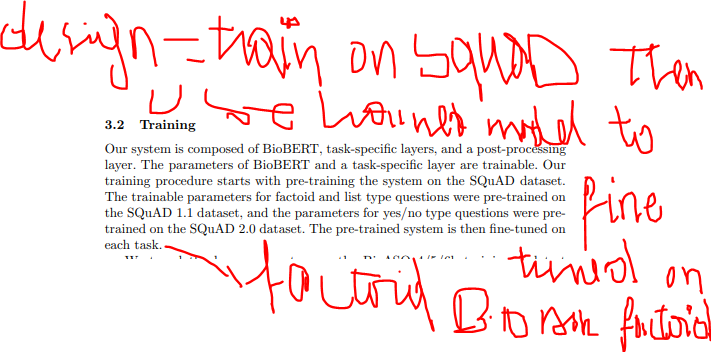

# BioBERT first pre-trained on SQuAD and then fine-tuned on BioASQ 6b obtained the best performance over other two experiments, demonstrating the effectiveness of pretraining BioBERT on SQuAD, a comprehensive and large-scale question answering corpus.


In [ ]:
###NEXT STEP TO IMPROVE F1 SCORE OF 66. 
### investigate why full context with title failed and remove title to see if trained work
##### ANOTHER APPROACH USE  FULL CONTEX WITHOUT TITLE INSTEAD OF SNIPPET TO TRAINED AND TEST THE MODEL USING DATA BELOW BUT WE MUST REMOVE THE IMPOSSIBLE QUESTION.
##C:\Users\radjoko\Downloads\CapstoneA\dataset\BIOASK_full dataset\model train_test_data

In [ ]:
### before training make sure data ins in bert folder
#### KEY STEP ########################
## understanding parameter:
#1. debug_final_factoid_squad_full.json(see as test file) is similar to to the dev.json from squad this is use for testing the trained model , it will generate a prediction.json that will use to assess our mode
#2. train_factoid_squad_full.json (see as train file ) similar to the train.json in squad this is use to fine tune the model
#3. test_factoid_squad_full.json this actually and extension of the test  file what we use to evaluate the model , see it as extended testing file, in this file you can omit the the answer  and run the TESTING MODEL 
#4. run the evaluation script frrom squad to get f1 score and other metric: https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/  and https://rajpurkar.github.io/SQuAD-explorer/
!python run_squad.py \
  --vocab_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/vocab.txt \
  --bert_config_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_config.json \
  --init_checkpoint=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_model.ckpt \
  --do_train=True \
  --train_file=$BUCKET_NAME/snippet_train_factoid_squad_full.json \
  --do_predict=True \
  --predict_file=$BUCKET_NAME/dev-test_factoid_squad_full_NO_IMPOSSIBLE.json \
  --train_batch_size=24 \
  --learning_rate=3e-5 \
  --num_train_epochs=2.0 \
  --use_tpu=True \
  --tpu_name=grpc://10.127.151.122:8470 \
  --max_seq_length=384 \
  --doc_stride=128 \
  --version_2_with_negative=True \
  --output_dir=$OUTPUT_DIR

In [ ]:
%tensorflow_version 1.x ##switch  tensor flow version: https://github.com/google-research/bert/issues/934

In [ ]:
### using snippet data  f1 score


### using snippet data  f1 score
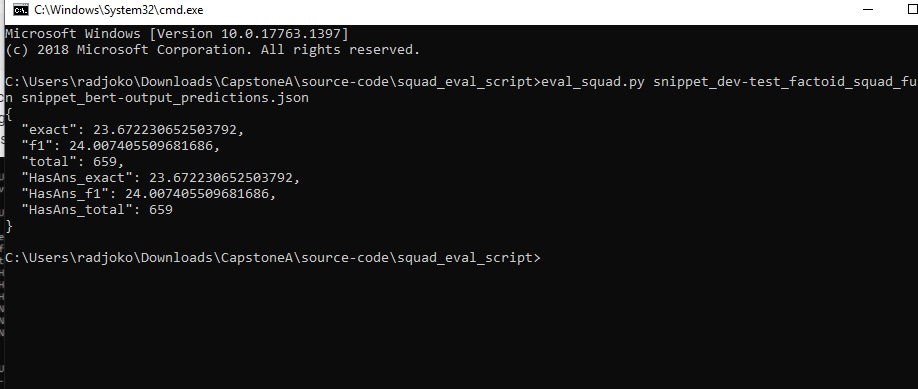
#  
)

### SNIPPPET AFTER REMOVING  IMPOSSIBLE FALSE FROM DEV DATA
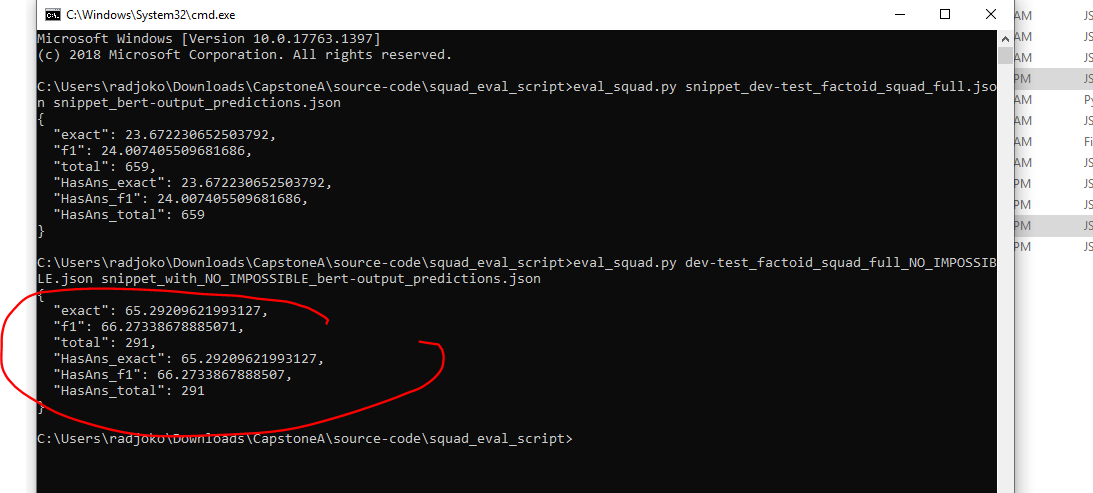

In [ ]:
###### USING TRAINED SAVED MODEL model.ckpt-654  TO PREDICT DEV DATA THE SAME AS ABOVE , TEST WITHOUT TRAINING GIVE THE SAME ACCURACY AS  ABOVE SO 
######### WE CONFIRMED THAT THE MODEL TRAINED DO THE TESTING USING THE FINE TUNE MODEL #########
!python run_squad.py \
  --vocab_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/vocab.txt \
  --bert_config_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_config.json \
  --init_checkpoint=gs://bertqa-bucket/bert-output/model.ckpt-654 \
  --do_train=False \
  --train_file=$BUCKET_NAME/snippet_train_factoid_squad_full.json \
  --do_predict=True \
  --predict_file=$BUCKET_NAME/dev-test_factoid_squad_full_NO_IMPOSSIBLE.json \
  --train_batch_size=24 \
  --learning_rate=3e-5 \
  --num_train_epochs=2.0 \
  --use_tpu=True \
  --tpu_name=grpc://10.39.69.90:8470 \
  --max_seq_length=384 \
  --doc_stride=128 \
  --version_2_with_negative=True \
  --output_dir=$OUTPUT_DIR






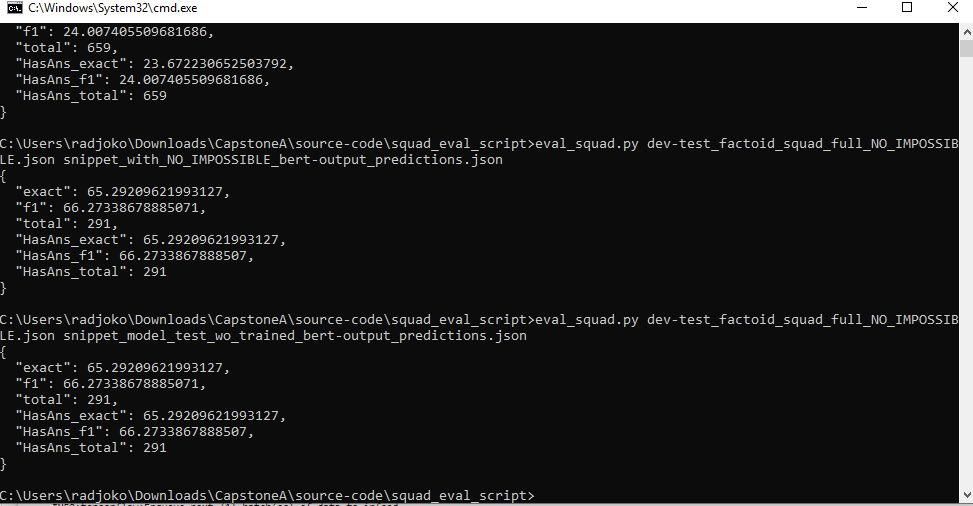

In [ ]:
#################TESTING ORIGINAL BERT ON BIOASK  DATA(dev-test_factoid_squad_full_NO_IMPOSSIBLE.json)  which return F1 SCORE SIMILAR TO the fine tune modle 65 ######################## 
######### WE CONFIRMED THAT THE MODEL TRAINED DO THE TESTING USING THE FINE TUNE MODEL #########debug_full_context_test_data.json


############## TEMP USE FOR TRAINING AND TESTING USING  FULL CONTEXT F1 = 17 NEXT STEP REMOVE IS IMPOSSIBLE DO TRAIN AND TEST. USE FOR DEBUGGINBG FULL CONTEXT WHERE THE DEV_TEST_FACTOID DATA WAS USED TRAINED THE DATA SUCCESSFULLY ################
!python run_squad.py \
  --vocab_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/vocab.txt \
  --bert_config_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_config.json \
  --init_checkpoint=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_model.ckpt \
  --do_train=True \
  --train_file=$BUCKET_NAME/train_factoid_squad_full.json \
  --do_predict=True \
  --predict_file=$BUCKET_NAME/dev-test_factoid_squad_full.json \
  --train_batch_size=24 \
  --learning_rate=3e-5 \
  --num_train_epochs=2.0 \
  --use_tpu=True \
  --tpu_name=grpc://10.68.170.66:8470 \
  --max_seq_length=384 \
  --doc_stride=128 \
  --version_2_with_negative=True \
  --output_dir=$OUTPUT_DIR

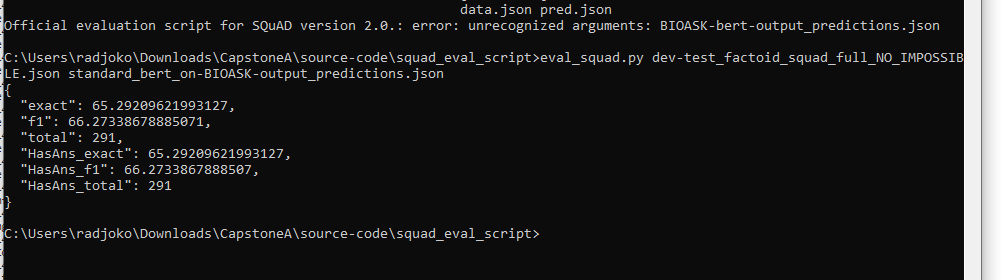

In [ ]:
##### removing all entry from impossible answer from the test set
with open("snippet_dev-test_factoid_squad_full.json", "r") as reader:
  test_data = json.load(reader)
  test_data_wo_I = []
  for entry in test_data['data']:
    if entry['paragraphs'][0]['qas'][0]['is_impossible'] == False:
      test_data_wo_I.append(entry)
test_data_wo_I
# with open(snippet_dev-test_factoid_squad_full.json, "r", encoding="utf-8") as reader: # for both training and test data 
#   test_data = json.load(reader)#["questions"]
# factoid_squad = bioask_to_squad_parser(input_data) #### main function taking few hours 
# final_factoid_squad = {

In [ ]:
######################### save the dev with no imposible answer ###############
final_snippet_dev = {
    "version": "7b",
    "data": test_data_wo_I
}
#convert dict to json and save the data as json file format
final_snippet_dev_json = json.dumps(final_snippet_dev, indent=4)
parsed = json.loads(final_snippet_dev_json)
with open('dev-test_factoid_squad_full_NO_IMPOSSIBLE.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4)

In [ ]:
!gsutil mv /content/dev-test_factoid_squad_full_NO_IMPOSSIBLE.json $BUCKET_NAME ## 
# !gsutil mv dev-test_factoid_squad_full_NO_IMPOSSIBLE.json $BUCKET_NAME ## copy squad json  snippet

In [ ]:
test_data['data'][0]['paragraphs'][0]#['is_impossible']

In [ ]:
############################ removing impossible from dataset ##############################
#upload the data to Colab environment need to run only once
from google.colab import files
uploaded = files.upload()
#read uploade json file


In [ ]:
# import json
# with open("train_factoid_squad_full.json", "r") as reader:
#   input_data = json.load(reader)

In [ ]:
##### part 2 removing all entry from impossible answer from the train and test if the full context data
with open("dev-test_factoid_squad_full.json", "r") as reader:
  test_data = json.load(reader)
  test_data_wo_I = []
  for entry in test_data['data']:
    if entry['paragraphs'][0]['qas'][0]['is_impossible'] == False:
      test_data_wo_I.append(entry)
test_data_wo_I
# with open(snippet_dev-test_factoid_squad_full.json, "r", encoding="utf-8") as reader: # for both training and test data 
#   test_data = json.load(reader)#["questions"]
# factoid_squad = bioask_to_squad_parser(input_data) #### main function taking few hours 
# final_factoid_squad = {

In [ ]:
final_snippet_dev = {
    "version": "7b",
    "data": test_data_wo_I
}
#convert dict to json and save the data as json file format
final_snippet_dev_json = json.dumps(final_snippet_dev, indent=4)
parsed = json.loads(final_snippet_dev_json)
with open('dev-test_factoid_squad_full_NO_IMPOSSIBLE.json', 'w') as json_file:
    json.dump(parsed, json_file, indent=4)

In [ ]:
!gsutil mv dev-test_factoid_squad_full_NO_IMPOSSIBLE.json $BUCKET_NAME ## 
# !gsutil mv dev-test_factoid_squad_full_NO_IMPOSSIBLE.json $BUCKET_NAME ## copy squad json  snippet

In [ ]:
test_data['data'][0]['paragraphs'][0]['qas'][0]['is_impossible']

In [ ]:
#### USE THE FULL CONTEXT WITHOUT IMPOSSIBLE TO TEST AND TRAINED
!python run_squad.py \
  --vocab_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/vocab.txt \
  --bert_config_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_config.json \
  --init_checkpoint=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_model.ckpt \
  --do_train=True \
  --train_file=$BUCKET_NAME/train_factoid_squad_full_NO_IMPOSSIBLE.json \
  --do_predict=True \
  --predict_file=$BUCKET_NAME/dev-test_factoid_squad_full_NO_IMPOSSIBLE.json \
  --train_batch_size=24 \
  --learning_rate=3e-5 \
  --num_train_epochs=2.0 \
  --use_tpu=True \
  --tpu_name=grpc://10.66.72.250:8470 \
  --max_seq_length=384 \
  --doc_stride=128 \
  --version_2_with_negative=True \
  --output_dir=$OUTPUT_DIR

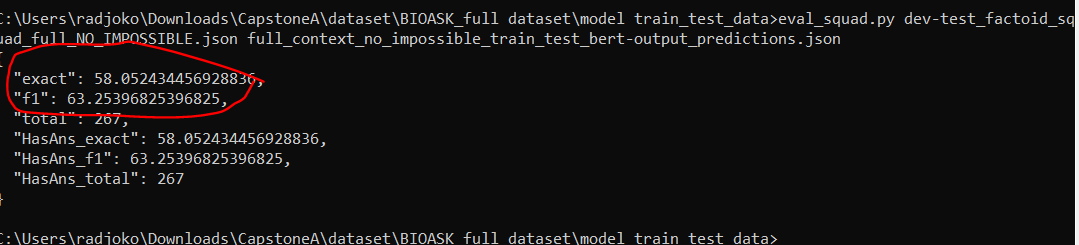



```
# This is formatted as code

```
## no need the  model test is already evaluatre during training one way to confirm that is by using the trained model to fine tune (with few trainin data and same dev test) so that i can focus on testing using the  dev data.
## TODO: RUN TESTING THIS SECTION CONSIST OF USING THE SAME DEV _TEST CODE IN TRAINING CONVERT TO THE TEST FORMAT AND RUN THE USING THE FINE TUNE MODEL THIS TO EVALUATE IF WE ARE GETTING BETTER PREDICTION FROM THE ONE IN TRAINING ####

# USE A differwent dataset that need to be parsed to the test form: C:\Users\radjoko\Downloads\CapstoneA\dataset\BIOASK_full dataset\Task7BGoldenEnriched:
1. make a dev test file for evalution
2. from the dev file  remove the answer block



In [ ]:
ls -l

In [ ]:
# TESTING DATA
%%writefile sample_question_file.json
{
    "version": "7b",
    "data": [
        {
            "title": "your_title",
            "paragraphs": [
                {
                    "qas": [
                        {
                            "question": "Name synonym of Acrokeratosis paraneoplastica.",
                            "id": "56bc751eac7ad10019000013",
                            "is_impossible": false
                        }
                    ],
                    "context": "Acrokeratosis paraneoplastica (Bazex syndrome) with oropharyngeal squamous cell carcinoma."
                }
            ]
        }
    ]
}

In [ ]:
# Run Prediction of  sample question:
import os
os.chdir('/content/bert/')
!python run_squad.py \
  --vocab_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/vocab.txt \
  --bert_config_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_config.json \
  --init_checkpoint=$OUTPUT_DIR/model.ckpt-180 \
  --do_train=False \
  --max_query_length=30  \
  --do_predict=True \
  --predict_file=predict_question_file.json \
  --predict_batch_size=8 \
  --n_best_size=3 \
  --max_seq_length=384 \
  --doc_stride=128 \
  --output_dir=output/


In [ ]:
!pwd
import os
os.chdir('/content/bert/output')
!pwd
with open("predictions.json", "r") as reader:
  input_data = json.load(reader)

In [ ]:
input_data["56bc751e"]

In [ ]:
#step 1 format
# ################# run prediction #################
# run prediction(question, context) --> print result
#1. format the question and  context in the input json format
#2. run the simple prediction 
#3. run prediction output and import it from Google cloud to notebook

In [ ]:
##FORMAT THE DATA
def format_input(question, context):
  import json
  # %%writefile predict_question_file.json
  user_input_data = {
      
    "version": "7b",
    "data": [
        {
            "title": "your_title",
            "paragraphs": [
                {
                    "qas": [
                        {
                            "question": question,
                            "id": "56bc751e",
                            "is_impossible":False
                        }
                    ],
                    "context": context
                }
            ]
        }
    ]
  }
  #convert dict to json and save the data as json file format
  user_input_json = json.dumps(user_input_data, indent=4)
  parsed = json.loads(user_input_json)
  os.chdir('/content/bert/')
  with open('predict_question_file.json', 'w') as json_file:
      json.dump(parsed, json_file, indent=4)

In [ ]:
# Run Prediction of  sample question:
def run_prediction(file):
  import os
  os.chdir('/content/bert/')
  print(file)
  # with open(file, "r") as f:
  !python run_squad.py \
    --vocab_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/vocab.txt \
    --bert_config_file=$BUCKET_NAME/uncased_L-24_H-1024_A-16/bert_config.json \
    --init_checkpoint=$OUTPUT_DIR/model.ckpt-180 \
    --do_train=False \
    --max_query_length=30  \
    --do_predict=True \
    --predict_file=$file \
    --predict_batch_size=8 \
    --n_best_size=3 \
    --max_seq_length=384 \
    --doc_stride=128 \
    --output_dir=output/

In [ ]:
def print_answer():
  os.chdir('/content/bert/output')
  # !pwd
  with open("predictions.json", "r") as reader:
    input_data = json.load(reader)
  return {"Answer":input_data['56bc751e']}

In [ ]:
print(print_answer())

In [ ]:
ls -l

In [ ]:
format_input("who create subway", " once uppon the time we had a nice story Rikel DJoko created subway")
run_prediction('predict_question_file.json')

In [ ]:
print(print_answer())

In [ ]:
# ## #upload the evaluation script to colab and save in buckcet
# from google.colab import files
# uploaded = files.upload()

In [ ]:
############## PUT ALL TOGETHER FOR DEMO  ################################
def Bioask_prediction(question, context):
  format_input(question, context)
  run_prediction(file)
  return print_answer()

In [ ]:
######### RUN DEMO ###############
Bioask_prediction("Name synonym of Acrokeratosis paraneoplastica", " Acrokeratosis paraneoplastic (Bazex syndrome) is a rare, but distinctive paraneoplastic dermatosis characterized by erythematosquamous lesions located at the acral sites and is most commonly associated with carcinomas of the upper aerodigestive tract. We report a 58-year-old female with a history of a pigmented rash on her extremities, thick keratotic plaques on her hands, and brittle nails. Chest imaging revealed a right upper lobe mass that was proven to be small cell lung carcinoma. While Bazex syndrome has been described in the dermatology literature, it is also important for the radiologist to be aware of this entity and its common presentations")

In [ ]:
ls -l


In [ ]:
#upload the evaluation script to colab and save in buckcet
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

In [ ]:
ls-l

In [ ]:
#load test file
from google.colab import files
uploaded = files.upload()

In [ ]:
# load prediction file 
from google.colab import files
uploaded = files.upload()

#### Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. ... In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model 

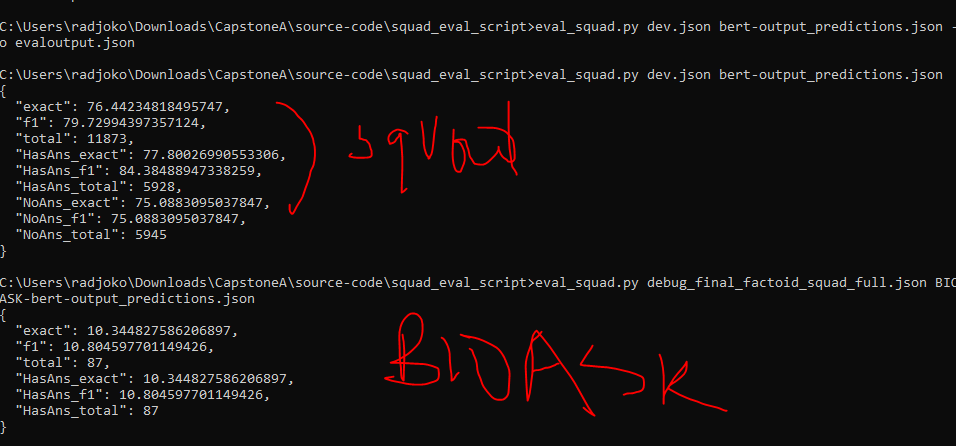

In [ ]:
# import eval_squad.py
!python mylib.py debug_final_factoid_squad_full.json BIOASK-bert-output_predictions.json

In [ ]:
############## NEX STEP RUN EVAL SCRIPT AND RUN ON DEV.json AND PREDICTION.json FROM DEV
##################### EVALUATION SCRIPT ##################################
"""Official evaluation script for SQuAD version 2.0.

In addition to basic functionality, we also compute additional statistics and
plot precision-recall curves if an additional na_prob.json file is provided.
This file is expected to map question ID's to the model's predicted probability
that a question is unanswerable.
"""
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys

OPTS = None

def parse_args():
  parser = argparse.ArgumentParser('Official evaluation script for SQuAD version 2.0.')
  parser.add_argument('data_file', metavar='data.json', help='Input data JSON file.')
  parser.add_argument('pred_file', metavar='pred.json', help='Model predictions.')
  parser.add_argument('--out-file', '-o', metavar='eval.json',
                      help='Write accuracy metrics to file (default is stdout).')
  parser.add_argument('--na-prob-file', '-n', metavar='na_prob.json',
                      help='Model estimates of probability of no answer.')
  parser.add_argument('--na-prob-thresh', '-t', type=float, default=1.0,
                      help='Predict "" if no-answer probability exceeds this (default = 1.0).')
  parser.add_argument('--out-image-dir', '-p', metavar='out_images', default=None,
                      help='Save precision-recall curves to directory.')
  parser.add_argument('--verbose', '-v', action='store_true')
  if len(sys.argv) == 1:
    parser.print_help()
    sys.exit(1)
  return parser.parse_args()

def make_qid_to_has_ans(dataset):
  qid_to_has_ans = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid_to_has_ans[qa['id']] = bool(qa['answers'])
  return qid_to_has_ans

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def get_raw_scores(dataset, preds):
  exact_scores = {}
  f1_scores = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid = qa['id']
        gold_answers = [a['text'] for a in qa['answers']
                        if normalize_answer(a['text'])]
        if not gold_answers:
          # For unanswerable questions, only correct answer is empty string
          gold_answers = ['']
        if qid not in preds:
          print('Missing prediction for %s' % qid)
          continue
        a_pred = preds[qid]
        # Take max over all gold answers
        exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
        f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
  return exact_scores, f1_scores

def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans, na_prob_thresh):
  new_scores = {}
  for qid, s in scores.items():
    pred_na = na_probs[qid] > na_prob_thresh
    if pred_na:
      new_scores[qid] = float(not qid_to_has_ans[qid])
    else:
      new_scores[qid] = s
  return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
  if not qid_list:
    total = len(exact_scores)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores.values()) / total),
        ('f1', 100.0 * sum(f1_scores.values()) / total),
        ('total', total),
    ])
  else:
    total = len(qid_list)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores[k] for k in qid_list) / total),
        ('f1', 100.0 * sum(f1_scores[k] for k in qid_list) / total),
        ('total', total),
    ])

def merge_eval(main_eval, new_eval, prefix):
  for k in new_eval:
    main_eval['%s_%s' % (prefix, k)] = new_eval[k]

def plot_pr_curve(precisions, recalls, out_image, title):
  plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
  plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.title(title)
  plt.savefig(out_image)
  plt.clf()

def make_precision_recall_eval(scores, na_probs, num_true_pos, qid_to_has_ans,
                               out_image=None, title=None):
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  true_pos = 0.0
  cur_p = 1.0
  cur_r = 0.0
  precisions = [1.0]
  recalls = [0.0]
  avg_prec = 0.0
  for i, qid in enumerate(qid_list):
    if qid_to_has_ans[qid]:
      true_pos += scores[qid]
    cur_p = true_pos / float(i+1)
    cur_r = true_pos / float(num_true_pos)
    if i == len(qid_list) - 1 or na_probs[qid] != na_probs[qid_list[i+1]]:
      # i.e., if we can put a threshold after this point
      avg_prec += cur_p * (cur_r - recalls[-1])
      precisions.append(cur_p)
      recalls.append(cur_r)
  if out_image:
    plot_pr_curve(precisions, recalls, out_image, title)
  return {'ap': 100.0 * avg_prec}

def run_precision_recall_analysis(main_eval, exact_raw, f1_raw, na_probs, 
                                  qid_to_has_ans, out_image_dir):
  if out_image_dir and not os.path.exists(out_image_dir):
    os.makedirs(out_image_dir)
  num_true_pos = sum(1 for v in qid_to_has_ans.values() if v)
  if num_true_pos == 0:
    return
  pr_exact = make_precision_recall_eval(
      exact_raw, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_exact.png'),
      title='Precision-Recall curve for Exact Match score')
  pr_f1 = make_precision_recall_eval(
      f1_raw, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_f1.png'),
      title='Precision-Recall curve for F1 score')
  oracle_scores = {k: float(v) for k, v in qid_to_has_ans.items()}
  pr_oracle = make_precision_recall_eval(
      oracle_scores, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_oracle.png'),
      title='Oracle Precision-Recall curve (binary task of HasAns vs. NoAns)')
  merge_eval(main_eval, pr_exact, 'pr_exact')
  merge_eval(main_eval, pr_f1, 'pr_f1')
  merge_eval(main_eval, pr_oracle, 'pr_oracle')

def histogram_na_prob(na_probs, qid_list, image_dir, name):
  if not qid_list:
    return
  x = [na_probs[k] for k in qid_list]
  weights = np.ones_like(x) / float(len(x))
  plt.hist(x, weights=weights, bins=20, range=(0.0, 1.0))
  plt.xlabel('Model probability of no-answer')
  plt.ylabel('Proportion of dataset')
  plt.title('Histogram of no-answer probability: %s' % name)
  plt.savefig(os.path.join(image_dir, 'na_prob_hist_%s.png' % name))
  plt.clf()

def find_best_thresh(preds, scores, na_probs, qid_to_has_ans):
  num_no_ans = sum(1 for k in qid_to_has_ans if not qid_to_has_ans[k])
  cur_score = num_no_ans
  best_score = cur_score
  best_thresh = 0.0
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  for i, qid in enumerate(qid_list):
    if qid not in scores: continue
    if qid_to_has_ans[qid]:
      diff = scores[qid]
    else:
      if preds[qid]:
        diff = -1
      else:
        diff = 0
    cur_score += diff
    if cur_score > best_score:
      best_score = cur_score
      best_thresh = na_probs[qid]
  return 100.0 * best_score / len(scores), best_thresh

def find_all_best_thresh(main_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans):
  best_exact, exact_thresh = find_best_thresh(preds, exact_raw, na_probs, qid_to_has_ans)
  best_f1, f1_thresh = find_best_thresh(preds, f1_raw, na_probs, qid_to_has_ans)
  main_eval['best_exact'] = best_exact
  main_eval['best_exact_thresh'] = exact_thresh
  main_eval['best_f1'] = best_f1
  main_eval['best_f1_thresh'] = f1_thresh

def main():
  with open(OPTS.data_file) as f:
    dataset_json = json.load(f)
    dataset = dataset_json['data']
  with open(OPTS.pred_file) as f:
    preds = json.load(f)
  if OPTS.na_prob_file:
    with open(OPTS.na_prob_file) as f:
      na_probs = json.load(f)
  else:
    na_probs = {k: 0.0 for k in preds}
  qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
  has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
  no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
  exact_raw, f1_raw = get_raw_scores(dataset, preds)
  exact_thresh = apply_no_ans_threshold(exact_raw, na_probs, qid_to_has_ans,
                                        OPTS.na_prob_thresh)
  f1_thresh = apply_no_ans_threshold(f1_raw, na_probs, qid_to_has_ans,
                                     OPTS.na_prob_thresh)
  out_eval = make_eval_dict(exact_thresh, f1_thresh)
  if has_ans_qids:
    has_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=has_ans_qids)
    merge_eval(out_eval, has_ans_eval, 'HasAns')
  if no_ans_qids:
    no_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=no_ans_qids)
    merge_eval(out_eval, no_ans_eval, 'NoAns')
  if OPTS.na_prob_file:
    find_all_best_thresh(out_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans)
  if OPTS.na_prob_file and OPTS.out_image_dir:
    run_precision_recall_analysis(out_eval, exact_raw, f1_raw, na_probs, 
                                  qid_to_has_ans, OPTS.out_image_dir)
    histogram_na_prob(na_probs, has_ans_qids, OPTS.out_image_dir, 'hasAns')
    histogram_na_prob(na_probs, no_ans_qids, OPTS.out_image_dir, 'noAns')
  if OPTS.out_file:
    with open(OPTS.out_file, 'w') as f:
      json.dump(out_eval, f)
  else:
    print(json.dumps(out_eval, indent=2))

if __name__ == '__main__':
  OPTS = parse_args()
  if OPTS.out_image_dir:
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt 
  main()
